In [1]:

import geopandas as gpd
import rasterio
from rasterio.transform import from_origin
import numpy as np
import matplotlib.pyplot as plt

# Ladda din GPKG-fil med geopandas
gdf = gpd.read_file('papa_new_guinea.gpkg')
grid_gdf = gpd.read_file('world_grid_25000.gpgk')

# Projekt den till önskad CRS (i det här fallet ESRI:54034)
gdf = gdf.to_crs('ESRI:54034')
grid_gdf = grid_gdf.to_crs('ESRI:54034')


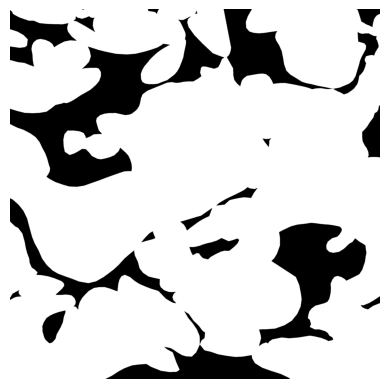

In [20]:
from rasterio import features
# Skapa en ny rasterbild med en kanal
raster = np.zeros((height, width))

# Konvertera polygonerna till raster där gränser är 1 och resten är 0
for _, row in gdf.iterrows():
    # Skapa en mask för varje polygon
    if not row['geometry'].is_empty:
        # Omvandla polygonen till pixelkoordinater
        polygon = row['geometry']
        mask = features.geometry_mask([polygon], transform=transform, invert=True, out_shape=(height, width))
        raster[mask] = 1

# Använd matplotlib för att skapa och spara bilden
plt.imshow(raster, cmap='gray', origin='upper')
plt.axis('off')  # Ta bort axlarna
plt.savefig('polygon_raster.png', bbox_inches='tight', pad_inches=0, dpi=200)


In [85]:

import geopandas as gpd
import rasterio
from rasterio.transform import from_origin
import numpy as np
from rasterio import features

import math

# Skapa en tom rasterbild där allt är svart (0)
pixel_size = 100
raster_size = 2560
width = 256
height = 256
transform = from_origin(west=x_origin, north=y_origin, xsize=pixel_size, ysize=pixel_size)
raster = np.zeros((height, width), dtype=np.uint8)

# Gå igenom varje polygon och rita ut gränserna på rasterbilden
for geom in gdf.geometry:
    # Omvandla varje polygon till en linjesträng (dess gränser)
    #boundary = geom.buffer(-10).boundary
    boundary = geom.boundary
    if not boundary.is_empty:
        # Rasterisera gränserna och uppdatera rasterbilden
        shapes = ((g, 255) for g in [boundary])
        burned = features.rasterize(shapes=shapes, fill=0, out=raster, transform=transform)
        raster |= burned  # Kombinera med OR-operation för att bevara befintliga vita gränser


fade_range = 4
for x in range(raster.shape[0]):
    for y in range(raster.shape[1]):
        distance = 999
        for x_offset in range(-fade_range,fade_range):
            for y_offset in range(-fade_range, fade_range):
                if x_offset != 0 and y_offset != 0:
                    if x + x_offset > 0 and x + x_offset < raster.shape[0]:
                        if y + y_offset > 0 and y + y_offset < raster.shape[1]:
                            if raster[x][y] < 250:
                                if raster[x + x_offset][y + y_offset] > 250:
                                    current_dist = math.sqrt(x_offset**2 + y_offset**2)
                                    if current_dist < distance:       
                                        distance = current_dist
                                        raster[x][y] = 200 / distance

# Spara den skapade rasterbilden
with rasterio.open(
    'polygon_boundaries.tif',
    'w',
    driver='GTiff',
    height=raster.shape[0],
    width=raster.shape[1],
    count=1,
    dtype=raster.dtype,
    crs='ESRI:54034',
    transform=transform,
) as dst:
    dst.write(raster, 1)


In [109]:
import os

image_files = os.listdir("google_earth_download_100_/projects_HII_v1_driver_railways")


In [4]:
import geopandas as gpd
import rasterio
from rasterio.transform import from_origin
import numpy as np
from rasterio import features
from scipy.ndimage import gaussian_filter
import os
from tifffile import imread
# Antag att gdf har laddats och projektionen har ställts in som tidigare

# Definiera ursprung och skapa en tom rasterbild
pixel_size = 100
raster_size = 2560
width = 256
height = 256

image_files = os.listdir("google_earth_download_100_/projects_HII_v1_driver_railways")
for index, image_file in enumerate(image_files):
    str_coords = image_file.split(']')[0].split('[')[1]
    coords = str_coords.split('_')

    if os.path.isfile(f'annotations/{str_coords}.tif') or not image_file.endswith(".tif"):
        print(image_file)
        continue
    img = imread("google_earth_download_100_/projects_HII_v1_driver_railways/"+image_file)
    height = img.shape[0]
    width  = img.shape[1]


    transform = from_origin(west=float(coords[1].split('.')[0]) - (pixel_size*width)/2, north=float(coords[0].split('.')[0]) + (pixel_size*height)/2, xsize=pixel_size, ysize=pixel_size)
    raster = np.zeros((height, width), dtype=np.uint8)

    # Rasterisera gränserna
    for geom in gdf.geometry:
        boundary = geom.boundary
        if not boundary.is_empty:
            shapes = ((g, 255) for g in [boundary])
            burned = features.rasterize(shapes=shapes, fill=0, out=raster, transform=transform)
            raster |= burned

    # Applicera Gaussian blur på rasterbilden
    sigma = 8  # Standardavvikelsen för Gaussian-kärnan, justera efter behov
    blurred = gaussian_filter(raster, sigma=sigma)

    # Normalisera det suddiga lagret så att det spänner över hela intervallet [0, 255]
    blurred_normalized = (blurred / blurred.max()) * 500
    blurred_normalized = np.clip(blurred_normalized, 0, 255).astype(np.uint8)
    #blurred_normalized = blurred_normalized.astype(np.uint8)
    write_geotif_at_location("google_earth_download_100_/projects_HII_v1_driver_railways/"+image_file,f'annotations/{str_coords}.tif' , blurred_normalized)
    # Spara den suddiga rasterbilden
    # with rasterio.open(
    #     f'annotations/{str_coords}.tif',
    #     'w',
    #     driver='GTiff',
    #     height=blurred_normalized.shape[0],
    #     width=blurred_normalized.shape[1],
    #     count=1,
    #     dtype=blurred_normalized.dtype,
    #     crs='ESRI:54034',
    #     transform=transform,
    # ) as dst:
    #     dst.write(blurred_normalized, 1)

    if index >= 3000:
        break

[-1007500.000000_14012500.000000]projects_HII_v1_driver_railways.tif
[-1007500.000000_14037500.000000]projects_HII_v1_driver_railways.tif
[-1007500.000000_15687500.000000]projects_HII_v1_driver_railways.tif
[-1007500.000000_15712500.000000]projects_HII_v1_driver_railways.tif
[-1007500.000000_15737500.000000]projects_HII_v1_driver_railways.tif
[-1007500.000000_15762500.000000]projects_HII_v1_driver_railways.tif
[-1007500.000000_15787500.000000]projects_HII_v1_driver_railways.tif
[-1007500.000000_15812500.000000]projects_HII_v1_driver_railways.tif
[-1007500.000000_15837500.000000]projects_HII_v1_driver_railways.tif
[-1007500.000000_15862500.000000]projects_HII_v1_driver_railways.tif
[-1007500.000000_15887500.000000]projects_HII_v1_driver_railways.tif
[-1007500.000000_15912500.000000]projects_HII_v1_driver_railways.tif
[-1007500.000000_15937500.000000]projects_HII_v1_driver_railways.tif
[-1007500.000000_15962500.000000]projects_HII_v1_driver_railways.tif
[-1007500.000000_16337500.000000]p

In [3]:
try:
    import gdal
except:
    from osgeo import gdal
    import osgeo.osr as osr
def write_geotif_at_location(ref_image_filepath, out_image_filepath, list_of_numpy_arr):
    '''

    Writes a geotif at the same position as a reference image. 
    Each band in the geotif is added in the list as np.array 
    
    input:
        ref_image_filepath (string) - path to georeferences image
        out_image_filepath (string) - path to output image
        list_of_numpy_arr (list)  - list of 2d nparrys, shape should be of same size as shape of ref_image_filepath
    output:
        None
    '''
    ds = gdal.Open(ref_image_filepath)
    band = ds.GetRasterBand(1)
    arr = band.ReadAsArray()
    [rows, cols] = arr.shape
    
    driver = gdal.GetDriverByName('GTiff')
    srs = osr.SpatialReference()
    outdata = driver.Create(out_image_filepath, cols, rows, len(list_of_numpy_arr), gdal.GDT_Float32, options=['COMPRESS=LZW'])
    srs.ImportFromEPSG(3006)
    outdata.SetProjection(srs.ExportToWkt())
    outdata.SetGeoTransform(ds.GetGeoTransform())##sets same geotransform as input
    outdata.SetProjection(ds.GetProjection())##sets same projection as input

    outdata.GetRasterBand(1).WriteArray(list_of_numpy_arr)
    outdata.FlushCache() ##saves to disk!!
    outdata = None
    band = None
    ds = None
    return None
